In [1]:
import pandas as pd
from collections import Counter
import pprint
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt

Load pre-trained embedding. See readme for training your own.

In [2]:
%load_ext autoreload
%autoreload 2
from code.feiii_transformers import _EmbeddingHolder
embedding = _EmbeddingHolder()
embedding.load('embedding')

# Load data

In [22]:
%load_ext autoreload
%autoreload 2

from code.feiii_experiment import evaluate, kfold
from code.feiii_data import DataHolder
from code.feiii_pipeline import FeiiiPipeline


def pp(obj):
    return pprint.pformat(obj).replace('\n','<br />')

data = DataHolder(eval_docs=2)
print('done')

out = '<table><tr><th></th><th>TRAINING</th><th>TESTING SET</th></tr>'
out+= '<tr><td>#ROWS</td><td>'+str(len(data.train_full))+'</td><td>'+str(len(data.test))+'</td></tr>'
out+= '<tr><td>ROLES</td><td>'+pp(dict(Counter(data.train_full['grp'])))+'</td><td>'+pp(dict(Counter(data.test['grp'])))+'</td></tr>'
out+= '<tr><td>DOCUMENTS</td><td>'+pp(dict(Counter(data.train_full['SOURCE'])))+'</td><td>'+pp(dict(Counter(data.test['SOURCE'])))+'</td></tr>'
out+= '<tr><td>COMPANIES</td><td>'+pp(dict(Counter(data.train_full['FILER_NAME'])))+'</td><td>'+pp(dict(Counter(data.test['FILER_NAME'])))+'</td></tr>'
out+= '<tr><td>Expert ratings</td><td>'
tmp = Counter(data.train_full['rating'])
out+= "ALL: [H]{:_>4d} [R]{:_>4d} [N]{:_>4d} [I]{:_>4d}<br/>".format(
    tmp.get('highly',0),tmp.get('relevant',0),tmp.get('neutral',0),tmp.get('irrelevant',0))
for c in data.train_full.filter(regex=("RATING")):
    tmp = Counter(data.train_full[c])
    out+="[H]{:_>3d} [R]{:_>3d} [N]{:_>3d} [I]{:_>3d} [x]{:_>3d} ({})<br/>".format(
        tmp.get("Highly relevant", 0), tmp.get("Relevant", 0),
        tmp.get("Neutral", 0),tmp.get("Irrelevant", 0),
        tmp.get(np.nan, 0), c)
out+= '</td><td>'
tmp = Counter(data.test['rating'])
out+= "ALL: [H]{:_>4d} [R]{:_>4d} [N]{:_>4d} [I]{:_>4d}<br/>".format(
    tmp.get('highly',0),tmp.get('relevant',0),tmp.get('neutral',0),tmp.get('irrelevant',0))
out+= '</td></tr>'
out+= '</table>'

HTML(out)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
reading file STATE-STREET_2016.csv with 23 entries.
reading file STATE-STREET_2014.csv with 26 entries.
reading file PNC_2016.csv with 33 entries.
reading file PNC_2014.csv with 38 entries.
reading file JPM_2016.csv with 52 entries.
reading file COMERICA_2016.csv with 11 entries.
reading file FIFTH-THIRD_2014.csv with 36 entries.
reading file CITIGROUP_2014.csv with 52 entries.
reading file AMERICAN-EXPRESS_2015.csv with 11 entries.
reading file BANK-OF-AMERICA_2015.csv with 74 entries.
reading file ALLY_2016.csv with 44 entries.
reading file CITIGROUP_2016.csv with 50 entries.
reading file ALLY_2014.csv with 40 entries.
reading file SUNTRUST_2013.csv with 35 entries.
reading file DISCOVER_2014.csv with 41 entries.
reading file MORGAN-STANLEY_2015.csv with 128 entries.
reading file SUNTRUST_2016.csv with 27 entries.
reading file BBT_2014.csv with 14 entries.
reading file GENERAL-ELECTRIC_2013.csv wi

,TRAINING,TESTING SET
#ROWS,975,900
ROLES,"{'affiliate': 186, 'agent': 61, 'counterpart': 64, 'guarantor': 34, 'insurer': 19, 'issuer': 129, 'seller': 20, 'servicer': 21, 'trustee': 420, 'underwriter': 21}","{'affiliate': 129, 'agent': 40, 'counterpart': 108, 'guarantor': 28, 'insurer': 47, 'issuer': 98, 'seller': 49, 'servicer': 57, 'trustee': 304, 'underwriter': 40}"
DOCUMENTS,"{'1393612-2013-FY': 41, '19617-2015-FY': 52, '28412-2015-FY': 11, '35527-2013-FY': 36, '35527-2014-FY': 46, '36270-m&t-2012': 21, '36270-m&t-2014': 21, '40545-2012-FY': 21, '40729-2013-FY': 40, '40729-2015-FY': 44, '4962-2014-FY': 11, '70858-2012-FY': 88, '70858-2014-FY': 74, '713676-2013-FY': 38, '713676-2015-FY': 33, '73124-2012-FY': 18, '750556-2012-FY': 35, '750556-2015-FY': 27, '831001-2013-FY': 52, '831001-2015-FY': 50, '895421-2014-FY': 128, '92230-2013-FY': 14, '927628-2012-FY': 25, '93751-2013-FY': 26, '93751-2015-FY': 23}","{'1026214-2011-Q2': 64, '1026214-2013-FY': 99, '109380-2014-FY': 13, '1390777-2015-Q1': 26, '1393612-2010-FY': 11, '19617-2011-FY': 67, '28412-2012-FY': 11, '310522-2012-FY': 59, '310522-2013-Q2': 21, '316709-2015-FY': 14, '36104-_2015-FY': 8, '36270-m&t-2010': 18, '40545-2015-FY': 27, '40729-2012-Q3': 23, '4962-2015-FY': 19, '70858-2013-FY': 81, '713676-2014-FY': 33, '73124-2015-FY': 28, '831001-2011-FY': 37, '886982-2013-FY': 36, '895421-2015-FY': 134, '91576-2012-FY': 10, '92230-2010-FY': 21, '927628-2010-FY': 20, '93751-2010-FY': 20}"
COMPANIES,"{'AMERICAN EXPRESS CO': 11, 'Ally Financial Inc': 84, 'BANK OF AMERICA CORP': 162, 'BB&T CORP': 14, 'CAPITAL ONE FINANCIAL CORP': 25, 'CITIGROUP INC': 102, 'COMERICA INC': 11, 'Discover Financial Services': 41, 'FIFTH THIRD BANCORP': 82, 'GENERAL ELECTRIC CO': 21, 'JPMORGAN CHASE & CO': 52, 'M&T BANK CORP': 42, 'MORGAN STANLEY': 128, 'NORTHERN TRUST CORP': 18, 'PNC FINANCIAL SERVICES GROUP INC': 71, 'STATE STREET CORP': 49, 'SUNTRUST BANKS INC': 62}","{'AMERICAN EXPRESS CO': 19, 'Ally Financial Inc': 23, 'BANK OF AMERICA CORP': 81, 'BB&T CORP': 21, 'Bank of New York Mellon Corp': 26, 'CAPITAL ONE FINANCIAL CORP': 20, 'CITIGROUP INC': 37, 'COMERICA INC': 11, 'Discover Financial Services': 11, 'FEDERAL_HOME_LOAN_MORTGAGE_CORP': 163, 'FEDERAL_NATIONAL_MORTGAGE_ASSOCIATION_FANNIE_MAE': 80, 'GENERAL ELECTRIC CO': 27, 'GOLDMAN SACHS GROUP INC': 36, 'JPMORGAN CHASE & CO': 67, 'KEYCORP': 10, 'M&T BANK CORP': 18, 'MORGAN STANLEY': 134, 'NORTHERN TRUST CORP': 28, 'PNC FINANCIAL SERVICES GROUP INC': 33, 'SCHWAB_CHARLES_CORP ': 14, 'STATE STREET CORP': 20, 'US_BANCORP': 8, 'ZIONS BANCORPORATION': 13}"
Expert ratings,"RATING_EXPERT_1 Counter({nan: 566, 'Highly relevant': 149, 'Neutral': 139, 'Relevant': 93, 'Irrelevant': 28})RATING_EXPERT_1.1 Counter({nan: 749, 'Highly relevant': 101, 'Neutral': 83, 'Relevant': 35, 'Irrelevant': 7})RATING_EXPERT_10 Counter({nan: 955, 'Relevant': 20})RATING_EXPERT_2 Counter({nan: 609, 'Relevant': 163, 'Neutral': 131, 'Highly relevant': 58, 'Irrelevant': 14})RATING_EXPERT_3 Counter({nan: 915, 'Irrelevant': 29, 'Neutral': 15, 'Highly relevant': 8, 'Relevant': 8})RATING_EXPERT_4 Counter({nan: 940, 'Relevant': 23, 'Neutral': 5, 'Highly relevant': 5, 'Irrelevant': 2})RATING_EXPERT_5 Counter({nan: 895, 'Neutral': 41, 'Relevant': 29, 'Highly relevant': 7, 'Irrelevant': 3})RATING_EXPERT_6 Counter({nan: 915, 'Relevant': 34, 'Highly relevant': 10, 'Irrelevant': 10, 'Neutral': 6})RATING_EXPERT_7 Counter({nan: 900, 'Neutral': 36, 'Relevant': 27, 'Highly relevant': 10, 'Irrelevant': 2})RATING_EXPERT_9 Counter({nan: 901, 'Highly relevant': 62, 'Irrelevant': 10, 'Neutral': 1, 'Relevant': 1})","Counter({'relevant': 369, 'highly': 309, 'neutral': 142, 'irrelevant': 80})"


Execute the following line in case of errors during training.

In [10]:
data.shuffle_train_eval(n_docs_eval=0, max_tries=5)

# Train

In [24]:
fm, m, res, macro_res, conf_matrix_role, conf_matrix_full = evaluate(data, pipeline, score_func=score_func,predict_on='test')

Items in training set: 910 (93.33%)
Items in eval set: 65
Items in test set: 900
 = 1875
Number of source documents: 50 total, 23 train, 2 eval 25 test
Absolute (training): IR 74.00, N 289.00, R 259.00, HR 288.00
Relative (training): IR 0.08, N 0.32, R 0.28, HR 0.32
Absolute (eval): IR 16.00, N 18.00, R 24.00, HR 7.00
Relative (eval): IR 0.25, N 0.28, R 0.37, HR 0.11
Role samples for GUARANTOR in train: 22, eval: 12, test: 28
Role samples for SERVICER in train: 21, eval: 0, test: 57
Role samples for AGENT in train: 56, eval: 5, test: 40
Role samples for COUNTERPART in train: 63, eval: 1, test: 108
Role samples for TRUSTEE in train: 412, eval: 8, test: 304
Role samples for ISSUER in train: 122, eval: 7, test: 98
Role samples for UNDERWRITER in train: 14, eval: 7, test: 40
Role samples for SELLER in train: 20, eval: 0, test: 49
Role samples for INSURER in train: 19, eval: 0, test: 47
Role samples for AFFILIATE in train: 161, eval: 25, test: 129
=== GUARANTOR ======
Items in training set:

/home/tim/Uni/HPI/workspace/FEII/code/feiii_data.py:222: RuntimeWarning: invalid value encountered in true_divide
  rating_agg.sum()))
/home/tim/Uni/HPI/workspace/FEII/code/feiii_data.py:222: RuntimeWarning: invalid value encountered in true_divide
  rating_agg.sum()))


NDCG after 100x random order:
 > mean ndcg = nan | std = nan
NDCG for worst case (inverted best) order:
 > ndcg = nan
Accuracy | role : 0.40350877193
Accuracy | full : 0.649122807018
             precision    recall  f1-score   support

 irrelevant       0.18      1.00      0.30         3
    neutral       0.00      0.00      0.00         9
   relevant       0.85      0.89      0.87        38
     highly       0.00      0.00      0.00         7

avg / total       0.58      0.65      0.60        57

[[ 3  0  0  0]
 [ 6  0  3  0]
 [ 4  0 34  0]
 [ 4  0  3  0]]
> NDCG Score | role | categ  | 0.91002
> NDCG Score | role | proba* | 0.85743
> NDCG Score | full | categ  | 0.87935
> NDCG Score | full | proba* | 0.88095
=== TRUSTEE ======
Items in training set: 412 (98.10%)
Items in eval set: 8
Items in test set: 304
 = 724
Number of source documents: 40 total, 19 train, 2 eval 19 test
Absolute (training): IR 20.00, N 157.00, R 79.00, HR 156.00
Relative (training): IR 0.05, N 0.38, R 0.19, HR 0

/home/tim/Uni/HPI/workspace/FEII/code/feiii_data.py:222: RuntimeWarning: invalid value encountered in true_divide
  rating_agg.sum()))


NDCG after 100x random order:
 > mean ndcg = 0.620020893332 | std = 0.102111032104
NDCG for worst case (inverted best) order:
 > ndcg = 0.390859736659
Accuracy | role : 0.325581395349
Accuracy | full : 0.201550387597
             precision    recall  f1-score   support

 irrelevant       0.07      0.35      0.12        17
    neutral       0.00      0.00      0.00        12
   relevant       0.43      0.37      0.40        54
     highly       0.00      0.00      0.00        46

avg / total       0.19      0.20      0.18       129

[[ 6  0 11  0]
 [ 7  0  5  0]
 [32  2 20  0]
 [36  0 10  0]]
> NDCG Score | role | categ  | 0.87983
> NDCG Score | role | proba* | 0.87983
> NDCG Score | full | categ  | 0.84975
> NDCG Score | full | proba* | 0.89170
TOTAL NDCG | role | categ  | 0.97074
TOTAL NDCG | role | proba* | 0.95251
TOTAL NDCG | full | categ  | 0.94830
TOTAL NDCG | full | proba* | 0.93071


In [109]:
res, macro_res, conf_matrix_role, conf_matrix_full = kfold(5, data, pipeline, score_func, predict_on='test')

Leaving 3 docs out per fold


===                      CROSSEVAL ITERATION 1/5                     =====


Items in training set: 883 (90.56%)
Items in eval set: 92
Items in test set: 900
 = 1875
Number of source documents: 50 total, 22 train, 3 eval 25 test
Absolute (training): IR 87.00, N 292.00, R 221.00, HR 283.00
Relative (training): IR 0.10, N 0.33, R 0.25, HR 0.32
Absolute (eval): IR 3.00, N 15.00, R 62.00, HR 12.00
Relative (eval): IR 0.03, N 0.16, R 0.67, HR 0.13
Role samples for GUARANTOR in train: 22, eval: 12, test: 28
Role samples for SERVICER in train: 21, eval: 0, test: 57
Role samples for AGENT in train: 60, eval: 1, test: 40
Role samples for COUNTERPART in train: 61, eval: 3, test: 108
Role samples for TRUSTEE in train: 379, eval: 41, test: 304
Role samples for ISSUER in train: 117, eval: 12, test: 98
Role samples for UNDERWRITER in train: 20, eval: 1, test: 40
Role samples for SELLER in train: 17, eval: 3, test: 49
Role samples for INSURER in train: 18, eval: 1, test:

/home/tim/Uni/HPI/workspace/FEII/code/feiii_data.py:222: RuntimeWarning: invalid value encountered in true_divide
  rating_agg.sum()))


NDCG after 100x random order:
 > mean ndcg = nan | std = nan
NDCG for worst case (inverted best) order:
 > ndcg = nan
Accuracy | role : 0.122807017544
Accuracy | full : 0.684210526316
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         3
    neutral       0.00      0.00      0.00         9
   relevant       0.68      1.00      0.81        38
     highly       1.00      0.14      0.25         7

avg / total       0.58      0.68      0.57        57

[[ 0  0  3  0]
 [ 0  0  9  0]
 [ 0  0 38  0]
 [ 0  0  6  1]]
> NDCG Score | role | categ  | 0.85663
> NDCG Score | role | proba* | 0.87166
> NDCG Score | full | categ  | 0.88344
> NDCG Score | full | proba* | 0.85753
=== TRUSTEE ======
Items in training set: 379 (90.24%)
Items in eval set: 41
Items in test set: 304
 = 724
Number of source documents: 40 total, 18 train, 3 eval 19 test
Absolute (training): IR 21.00, N 161.00, R 41.00, HR 156.00
Relative (training): IR 0.06, N 0.42, R 0.11, HR

/home/tim/Uni/HPI/workspace/FEII/code/feiii_data.py:222: RuntimeWarning: invalid value encountered in true_divide
  rating_agg.sum()))


NDCG after 100x random order:
 > mean ndcg = 0.839561048753 | std = 0.0589751809864
NDCG for worst case (inverted best) order:
 > ndcg = 0.65841093381
Accuracy | role : 0.2
Accuracy | full : 0.2
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         4
    neutral       0.00      0.00      0.00         8
   relevant       0.27      0.53      0.36        15
     highly       0.00      0.00      0.00        13

avg / total       0.10      0.20      0.13        40

[[ 0  1  3  0]
 [ 0  0  8  0]
 [ 0  4  8  3]
 [ 0  2 11  0]]
> NDCG Score | role | categ  | 0.89290
> NDCG Score | role | proba* | 0.85306
> NDCG Score | full | categ  | 0.88825
> NDCG Score | full | proba* | 0.86365
=== COUNTERPART ======
Items in training set: 57 (89.06%)
Items in eval set: 7
Items in test set: 108
 = 172
Number of source documents: 31 total, 16 train, 1 eval 14 test
Absolute (training): IR 6.00, N 12.00, R 24.00, HR 15.00
Relative (training): IR 0.11, N 0.21, 

/home/tim/Uni/HPI/workspace/FEII/code/feiii_data.py:222: RuntimeWarning: invalid value encountered in true_divide
  rating_agg.sum()))
/home/tim/Uni/HPI/workspace/FEII/code/feiii_data.py:222: RuntimeWarning: invalid value encountered in true_divide
  rating_agg.sum()))


NDCG after 100x random order:
 > mean ndcg = nan | std = nan
NDCG for worst case (inverted best) order:
 > ndcg = nan
Accuracy | role : 0.122807017544
Accuracy | full : 0.666666666667
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         3
    neutral       0.00      0.00      0.00         9
   relevant       0.68      1.00      0.81        38
     highly       0.00      0.00      0.00         7

avg / total       0.45      0.67      0.54        57

[[ 0  0  3  0]
 [ 0  0  9  0]
 [ 0  0 38  0]
 [ 0  1  6  0]]
> NDCG Score | role | categ  | 0.85663
> NDCG Score | role | proba* | 0.87166
> NDCG Score | full | categ  | 0.85504
> NDCG Score | full | proba* | 0.84717
=== TRUSTEE ======
Items in training set: 417 (99.29%)
Items in eval set: 3
Items in test set: 304
 = 724
Number of source documents: 40 total, 20 train, 1 eval 19 test
Absolute (training): IR 21.00, N 161.00, R 79.00, HR 156.00
Relative (training): IR 0.05, N 0.39, R 0.19, HR 

/home/tim/Uni/HPI/workspace/FEII/code/feiii_data.py:222: RuntimeWarning: invalid value encountered in true_divide
  rating_agg.sum()))
/home/tim/Uni/HPI/workspace/FEII/code/feiii_data.py:222: RuntimeWarning: invalid value encountered in true_divide
  rating_agg.sum()))


NDCG after 100x random order:
 > mean ndcg = nan | std = nan
NDCG for worst case (inverted best) order:
 > ndcg = nan
Accuracy | role : 0.375
Accuracy | full : 0.275
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         3
    neutral       0.11      1.00      0.19         2
   relevant       0.43      0.60      0.50        15
     highly       0.00      0.00      0.00        20

avg / total       0.17      0.28      0.20        40

[[ 0  1  2  0]
 [ 0  2  0  0]
 [ 0  6  9  0]
 [ 0 10 10  0]]
> NDCG Score | role | categ  | 0.86908
> NDCG Score | role | proba* | 0.96398
> NDCG Score | full | categ  | 0.86842
> NDCG Score | full | proba* | 0.87527
=== SELLER ======
Items in training set: 20 (100.00%)
Items in eval set: 0
Items in test set: 49
 = 69
Number of source documents: 19 total, 10 train, 0 eval 9 test
Absolute (training): IR 0.00, N 1.00, R 14.00, HR 5.00
Relative (training): IR 0.00, N 0.05, R 0.70, HR 0.25
Absolute (eval): IR 0.

/home/tim/Uni/HPI/workspace/FEII/code/feiii_data.py:222: RuntimeWarning: invalid value encountered in true_divide
  rating_agg.sum()))


NDCG after 100x random order:
 > mean ndcg = 0.938633469979 | std = 0.033539000976
NDCG for worst case (inverted best) order:
 > ndcg = 0.920303207764
Accuracy | role : 0.2
Accuracy | full : 0.325
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         4
    neutral       0.00      0.00      0.00         8
   relevant       0.37      0.87      0.52        15
     highly       0.00      0.00      0.00        13

avg / total       0.14      0.33      0.20        40

[[ 0  1  3  0]
 [ 0  0  6  2]
 [ 0  1 13  1]
 [ 0  0 13  0]]
> NDCG Score | role | categ  | 0.89290
> NDCG Score | role | proba* | 0.85633
> NDCG Score | full | categ  | 0.84687
> NDCG Score | full | proba* | 0.79652
=== COUNTERPART ======
Items in training set: 52 (81.25%)
Items in eval set: 12
Items in test set: 108
 = 172
Number of source documents: 31 total, 15 train, 2 eval 14 test
Absolute (training): IR 3.00, N 12.00, R 30.00, HR 7.00
Relative (training): IR 0.06, N 0.23

/home/tim/Uni/HPI/workspace/FEII/code/feiii_data.py:222: RuntimeWarning: invalid value encountered in true_divide
  rating_agg.sum()))


NDCG after 100x random order:
 > mean ndcg = 1.0 | std = 0.0
NDCG for worst case (inverted best) order:
 > ndcg = 1.0
Accuracy | role : 0.122807017544
Accuracy | full : 0.649122807018
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         3
    neutral       0.00      0.00      0.00         9
   relevant       0.68      0.95      0.79        38
     highly       0.25      0.14      0.18         7

avg / total       0.48      0.65      0.55        57

[[ 0  0  3  0]
 [ 0  0  8  1]
 [ 0  0 36  2]
 [ 0  0  6  1]]
> NDCG Score | role | categ  | 0.85663
> NDCG Score | role | proba* | 0.84422
> NDCG Score | full | categ  | 0.87521
> NDCG Score | full | proba* | 0.89387
=== TRUSTEE ======
Items in training set: 381 (90.71%)
Items in eval set: 39
Items in test set: 304
 = 724
Number of source documents: 40 total, 18 train, 3 eval 19 test
Absolute (training): IR 20.00, N 143.00, R 62.00, HR 156.00
Relative (training): IR 0.05, N 0.38, R 0.16, HR

/home/tim/Uni/HPI/workspace/FEII/code/feiii_data.py:222: RuntimeWarning: invalid value encountered in true_divide
  rating_agg.sum()))


NDCG after 100x random order:
 > mean ndcg = nan | std = nan
NDCG for worst case (inverted best) order:
 > ndcg = nan
Accuracy | role : 0.34693877551
Accuracy | full : 0.367346938776
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         4
    neutral       0.17      0.10      0.12        10
   relevant       0.31      0.59      0.41        17
     highly       0.64      0.39      0.48        18

avg / total       0.38      0.37      0.34        49

[[ 0  0  4  0]
 [ 0  1  8  1]
 [ 0  4 10  3]
 [ 0  1 10  7]]
> NDCG Score | role | categ  | 0.80424
> NDCG Score | role | proba* | 0.86926
> NDCG Score | full | categ  | 0.92306
> NDCG Score | full | proba* | 0.89936
=== AFFILIATE ======
Items in training set: 160 (86.02%)
Items in eval set: 26
Items in test set: 129
 = 315
Number of source documents: 41 total, 20 train, 2 eval 19 test
Absolute (training): IR 16.00, N 31.00, R 57.00, HR 56.00
Relative (training): IR 0.10, N 0.19, R 0.36, HR 

/home/tim/Uni/HPI/workspace/FEII/code/feiii_data.py:222: RuntimeWarning: invalid value encountered in true_divide
  rating_agg.sum()))


NDCG after 100x random order:
 > mean ndcg = 0.830487445166 | std = 0.0572631031837
NDCG for worst case (inverted best) order:
 > ndcg = 0.73607743137
Accuracy | role : 0.2
Accuracy | full : 0.225
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         4
    neutral       0.00      0.00      0.00         8
   relevant       0.26      0.47      0.33        15
     highly       0.15      0.15      0.15        13

avg / total       0.15      0.23      0.18        40

[[ 0  0  3  1]
 [ 0  0  6  2]
 [ 0  0  7  8]
 [ 0  0 11  2]]
> NDCG Score | role | categ  | 0.89290
> NDCG Score | role | proba* | 0.90041
> NDCG Score | full | categ  | 0.88892
> NDCG Score | full | proba* | 0.83853
=== COUNTERPART ======
Items in training set: 63 (98.44%)
Items in eval set: 1
Items in test set: 108
 = 172
Number of source documents: 31 total, 16 train, 1 eval 14 test
Absolute (training): IR 6.00, N 12.00, R 29.00, HR 16.00
Relative (training): IR 0.10, N 0.19

# Evaluate trained classifier

In [110]:
pd.DataFrame(res).describe()

,acc_full,acc_role,baseline_rand,baseline_worst,f1_full,f1_role,ndcg_full,ndcg_full_proba,ndcg_role,ndcg_role_proba
count,50.000000,50.000000,40.000000,40.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.388052,0.406654,0.910372,0.818403,0.314622,0.280824,0.882182,0.878494,0.875601,0.901836
std,0.138206,0.170997,0.103925,0.185720,0.151217,0.186599,0.063615,0.055747,0.056086,0.050273
min,0.200000,0.122807,0.612471,0.383845,0.119354,0.026864,0.702504,0.720749,0.708118,0.754071
25%,0.275000,0.343679,0.869483,0.716033,0.195506,0.178726,0.856819,0.853105,0.856627,0.870239
50%,0.367347,0.375000,0.952526,0.888323,0.275120,0.204545,0.888248,0.882264,0.875147,0.898638
75%,0.426433,0.480263,1.000000,1.000000,0.429749,0.382138,0.919959,0.900386,0.896197,0.940617
max,0.684211,0.785714,1.000000,1.000000,0.593651,0.691429,0.984343,0.977051,0.973650,0.981214


In [104]:
out = ""
for ir, r in enumerate(data.get_roles()):
    out+="<h2>"+r.upper()+"</h2>"
    out+=pd.DataFrame(res).iloc[[ir+(ii*5) for ii in range(5)]].describe().to_html()
HTML(out)

,acc_full,acc_role,baseline_rand,baseline_worst,f1_full,f1_role,ndcg_full,ndcg_full_proba,ndcg_role,ndcg_role_proba
count,5.000000,5.000000,3.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.510432,0.584211,0.978612,0.930979,0.526110,0.558939,0.950289,0.956642,0.930653,0.958371
std,0.029253,0.134579,0.026210,0.061880,0.046023,0.144987,0.027016,0.033217,0.038142,0.028306
min,0.464286,0.450658,0.949374,0.880463,0.476768,0.409415,0.918337,0.918402,0.883185,0.917370
25%,0.506579,0.470395,0.967918,0.896469,0.494858,0.413077,0.929329,0.928040,0.915258,0.952020
50%,0.509868,0.607143,0.986461,0.912476,0.509369,0.613874,0.949208,0.958216,0.915258,0.952020
75%,0.535714,0.607143,0.993230,0.956238,0.570114,0.613874,0.976858,0.988770,0.965901,0.984420
max,0.535714,0.785714,1.000000,1.000000,0.579443,0.744454,0.977715,0.989785,0.973659,0.986023
,acc_full,acc_role,baseline_rand,baseline_worst,f1_full,f1_role,ndcg_full,ndcg_full_proba,ndcg_role,ndcg_role_proba
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


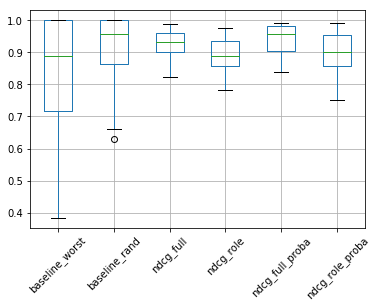

In [41]:
%matplotlib inline
pd.DataFrame(res)[['baseline_worst','baseline_rand','ndcg_full','ndcg_role','ndcg_full_proba','ndcg_role_proba']]\
    .boxplot(figsize=(5,8), rot=45)

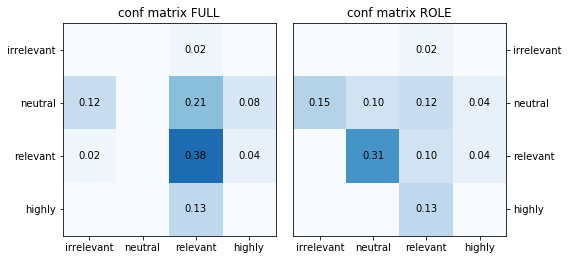

In [220]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm as colm
plt.figure(figsize=(8,5))
sub = plt.subplot(121)
normed = conf_matrix_full/conf_matrix_full.sum()
plt.imshow(normed, cmap=colm.Blues, vmax=0.5)
plt.title('conf matrix FULL')
sub.set_yticks([0,1,2,3])
sub.set_yticklabels(['irrelevant', 'neutral','relevant', 'highly'])
sub.set_xticks([0,1,2,3])
sub.set_xticklabels(['irrelevant', 'neutral','relevant', 'highly'])

for i in range(normed.shape[0]):
    for j in range(normed.shape[1]):
        v = normed.T[i][j]
        c='%.2f'%v if v>0.005 else ''
        sub.text(i, j, c, va='center', ha='center')



sub = plt.subplot(122)
normed = conf_matrix_role/conf_matrix_role.sum()
plt.imshow(normed, cmap=colm.Blues, vmax=0.5)
sub.yaxis.tick_right()
sub.set_yticks([0,1,2,3])
sub.set_yticklabels(['irrelevant', 'neutral','relevant', 'highly'])
sub.set_xticks([0,1,2,3])
sub.set_xticklabels(['irrelevant', 'neutral','relevant', 'highly'])

for i in range(normed.shape[0]):
    for j in range(normed.shape[1]):
        v = normed.T[i][j]
        c='%.2f'%v if v>0.01 else ''
        sub.text(i, j, c, va='center', ha='center')
        
plt.title('conf matrix ROLE')

plt.tight_layout()
plt.show()

# Save

affiliate 129
agent 40
counterpart 108
guarantor 28
insurer 47
issuer 98
seller 49
servicer 57
trustee 304
underwriter 40


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fde73627f98>], dtype=object)

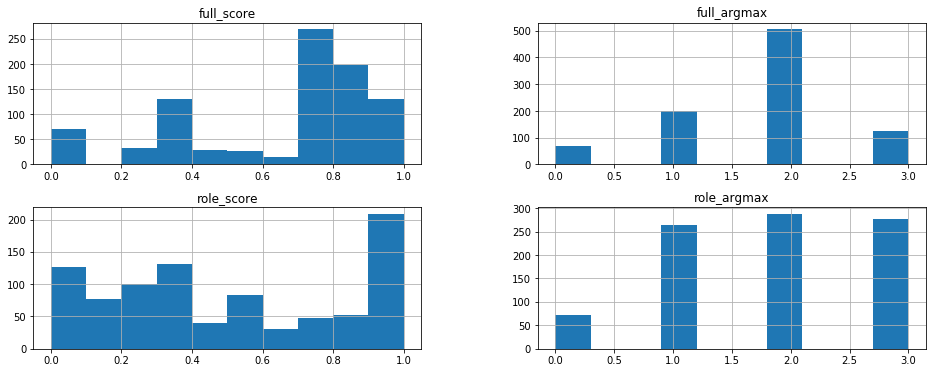

In [221]:
%matplotlib inline
def score_func(x, norm=True):
    kind = 'mulmax'
    if kind=='last':
        xx = x[-1]
    elif kind=='mulmax':
        xx = x.argmax(axis=1)*x.max(axis=1)
    elif kind=='maxadjust':
        xx = np.array([ai-xi[ai:ai+1].sum()+xi[ai+1:].sum() for xi,ai in zip(x,x.argmax(axis=1))])
    elif kind == '1234':
        xx = np.sum(x * np.array([1, 2, 3, 4]), axis=1)
    elif kind == '1246':
        xx = np.sum(x * np.array([1, 2, 4, 6]), axis=1)
    elif kind=='1245':
        xx = np.sum(x * np.array([1, 2, 4, 5]), axis=1)
    else:
        raise AttributeError('meh.')
        
    return (xx-xx.min())/(xx-xx.min()).max()

distribution_full = []
distribution_role = []
scores_full = []
scores_role = []

scored_full = []
scored_role = []

for role, frm in data.test.groupby('grp'):
    print(role, len(frm))
    fmpred, fmppred = fm.predict(frm)
    mpred, mppred = m[role].predict(frm)
    
    tmp = frm.copy()
    tmp['SCORE'] = score_func(fmppred)
    scored_full.append(tmp)
    
    tmp = frm.copy()
    tmp['SCORE'] = score_func(mppred)
    scored_role.append(tmp)
    
    distribution_full += list(fmpred)
    distribution_role += list(mpred)
    scores_full += list(score_func(fmppred))
    scores_role += list(score_func(mppred))
    
classifier = 'bow'
cols = ['SCORE', 'UNIQUE_ID', 'DOCUMENT_TYPE', 'FILER_NAME', 'FILER_CIK', 'FILING_INTERVAL', 'FILING_DATE', 
        'MENTIONED_FINANCIAL_ENTITY', 'ROLE', 'THREE_SENTENCES']

pd.concat(scored_full).sort_values(by=['grp', 'SCORE'], 
                                   ascending=[True, False])[cols].to_csv('scored_full_'+classifier+'.csv',
                                                                         index=False)
pd.concat(scored_role).sort_values(by=['grp', 'SCORE'], 
                                   ascending=[True, False])[cols].to_csv('scored_role_'+classifier+'.csv',
                                                                         index=False)


f, ax = plt.subplots(figsize=(16,6), nrows=2, ncols=2)
pd.DataFrame({'full_score':scores_full}).hist(ax=ax[0][0])
pd.DataFrame({'full_argmax':distribution_full}).hist(ax=ax[0][1])
pd.DataFrame({'role_score':scores_role}).hist(ax=ax[1][0])
pd.DataFrame({'role_argmax':distribution_role}).hist(ax=ax[1][1])

# Experiment with scoring functions

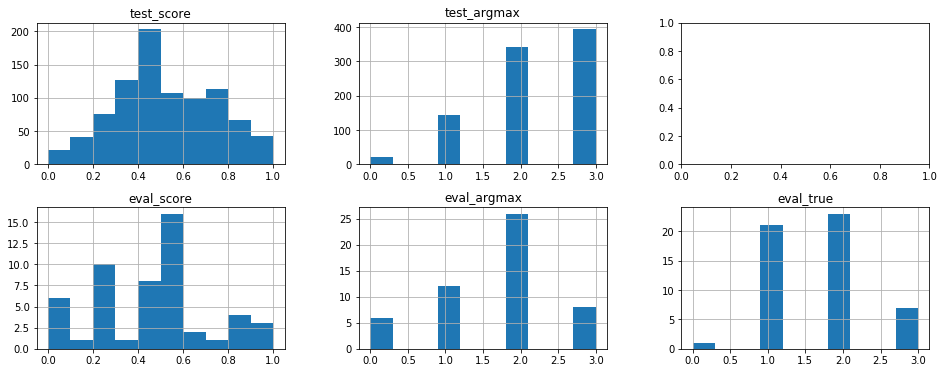

,test
count,900.000000
mean,0.522213
std,0.221250
min,0.000000
25%,0.384295
50%,0.489785
75%,0.698920
max,1.000000


In [206]:
%matplotlib inline
def score_func(x, norm=True):
    #return x.argmax(axis=1)
    #return np.sum(x * (np.ones_like(x)+ x.argmax(axis=1)), axis=1)
    #xx = ((x.argmax(axis=1))*x.argmax(axis=1)*x.max(axis=1))
    #xx= np.array([ai-xi[ai:ai+1].sum()+xi[ai+1:].sum() for xi,ai in zip(x,a)])
    #xx = x.argmax(axis=1)+x.max(axis=1)
    #xx = x.argmax(axis=1)*x.max(axis=1)*x.max(axis=1)
    #return xx
    kind = 'mulmax'
    if kind=='last':
        xx = x[-1]
    elif kind=='mulmax':
        xx = x.argmax(axis=1)*x.max(axis=1)
    elif kind=='maxadjust':
        xx = np.array([ai-xi[ai:ai+1].sum()+xi[ai+1:].sum() for xi,ai in zip(x,x.argmax(axis=1))])
    elif kind == '1234':
        xx = np.sum(x * np.array([1, 2, 3, 4]), axis=1)
    elif kind == '1246':
        xx = np.sum(x * np.array([1, 2, 4, 6]), axis=1)
    elif kind=='1245':
        xx = np.sum(x * np.array([1, 2, 4, 5]), axis=1)
    else:
        raise AttributeError('meh.')
        
    return (xx-xx.min())/(xx-xx.min()).max()

#pred, ppred = fm.predict(data.test)
#epred, eppred = fm.predict(data.eval)

f, ax = plt.subplots(figsize=(16,6), nrows=2, ncols=3)
pd.DataFrame({'test_score':score_func(ppred)}).hist(ax=ax[0][0])
pd.DataFrame({'test_argmax':pred}).hist(ax=ax[0][1])
pd.DataFrame({'eval_true':data.get_target(frm='eval')}).hist(ax=ax[1][2])
pd.DataFrame({'eval_score':score_func(eppred)}).hist(ax=ax[1][0])
pd.DataFrame({'eval_argmax':epred}).hist(ax=ax[1][1])
plt.show()
pd.DataFrame({'test':score_func(ppred, norm=False)}).describe()
#pd.DataFrame({'eval':score_func(eppred)})
#pd.DataFrame({'ppred':score_func(ppred), 'eppred':score_func(eppred)}).describe()